In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm
import seaborn as sns
from IPython import display
import geopandas as gpd

In [87]:
ts1 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\1to5ts.csv', index_col=[0])
ts2 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\7to17ts.csv', index_col=[0])
ts3 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\19to33ts.csv', index_col=[0])
ts4 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\35to45ts.csv', index_col=[0])

In [88]:
bigTSoil = pd.concat([ts1, ts2, ts3, ts4], axis=1)

In [89]:
bigTSoil = bigTSoil.loc[:, (bigTSoil != 0).any(axis=0)]
bigTSoil = bigTSoil.drop(columns=['3725354', '3725355'], axis=1)

In [414]:
Q0=bigTSoil['3729093'].rolling(window=1, center=False).mean().dropna().values
Q=Q0[np.where(Q0>1)[0][0]:]
T=range(0,len(Q))

In [5]:
from scipy.optimize import curve_fit

In [6]:
def decline_curve(curve_type, q_i):
    if curve_type == "exponential":
        def exponential_decline(T, a):
            return q_i*np.exp(-a*T)
        return exponential_decline
    
    elif curve_type == "hyperbolic":
        def hyperbolic_decline(T, a_i, b):
            return q_i/np.power((1+b*a_i*T), 1./b)
        return hyperbolic_decline
    
    elif curve_type == "harmonic":
        def parabolic_decline(T, a_i):
            return q_i/(1+a_i*T)
        return parabolic_decline
    
    else:
        raise "I don't know this decline curve!"

def L2_norm(Q, Q_obs):
    return np.sum(np.power(np.subtract(Q, Q_obs), 2))

In [417]:
exp_decline = decline_curve("exponential", Q[np.where(Q>0)[0][0]])
hyp_decline = decline_curve("hyperbolic", Q[np.where(Q>0)[0][0]])
har_decline = decline_curve("harmonic", Q[np.where(Q>0)[0][0]])

popt_exp, pcov_exp = curve_fit(exp_decline, T, Q, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T, Q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T, Q, method="trf")

print("L2 Norm of exponential decline: ", L2_norm(exp_decline(T, popt_exp[0]), Q))
print("L2 Norm of hyperbolic decline decline: ", L2_norm(hyp_decline(T, popt_hyp[0], popt_hyp[1]), Q))
print("L2 Norm of harmonic decline decline: ", L2_norm(har_decline(T, popt_har[0]), Q))

L2 Norm of exponential decline:  23121.258423671166
L2 Norm of hyperbolic decline decline:  18985.35489003022
L2 Norm of harmonic decline decline:  19144.286161750948


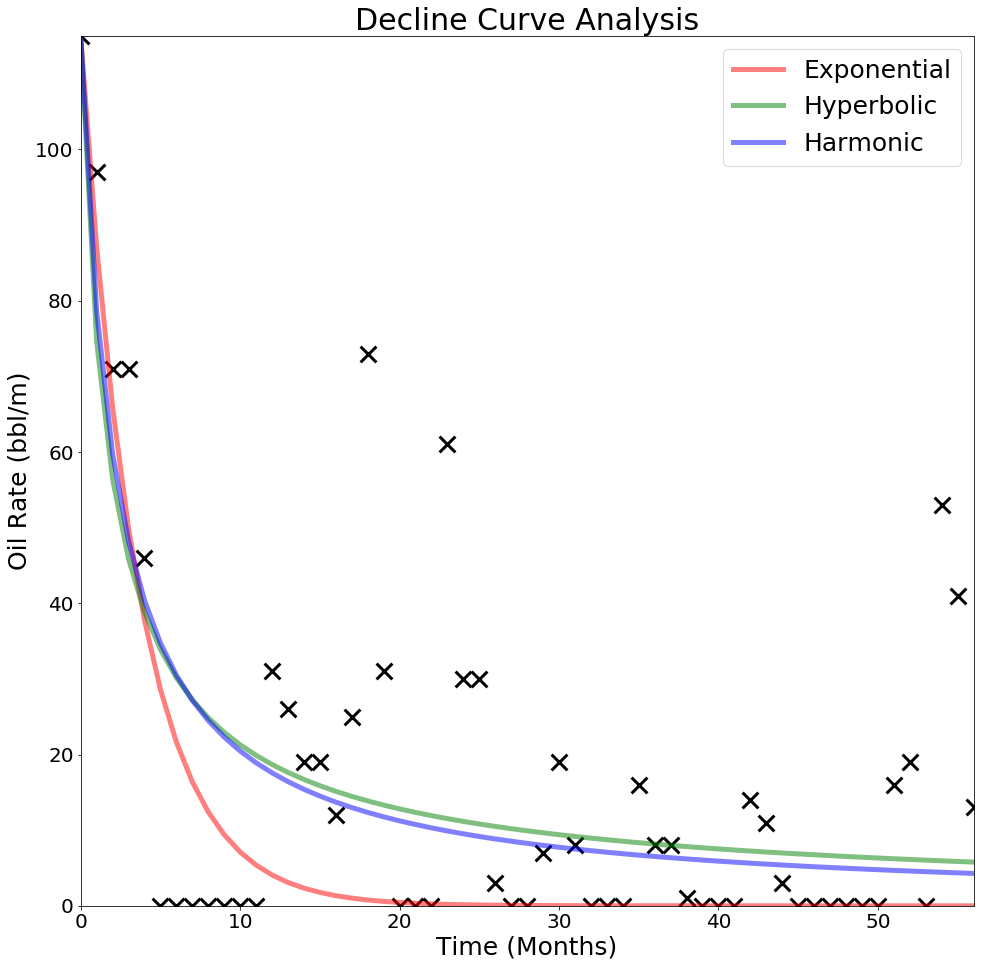

In [418]:
fig, ax = plt.subplots(1, figsize=(16, 16))

ax.set_title("Decline Curve Analysis", fontsize=30)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="black", marker="x", s=250, linewidth=3)
ax.set_xlabel("Time (Months)", fontsize=25)
ax.set_ylabel("Oil Rate (bbl/m)", fontsize=25)

pred_exp = exp_decline(T, popt_exp[0])
pred_hyp = hyp_decline(T, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T, popt_har[0])

min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.ticklabel_format(fontsize=25)
ax.legend(fontsize=25)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


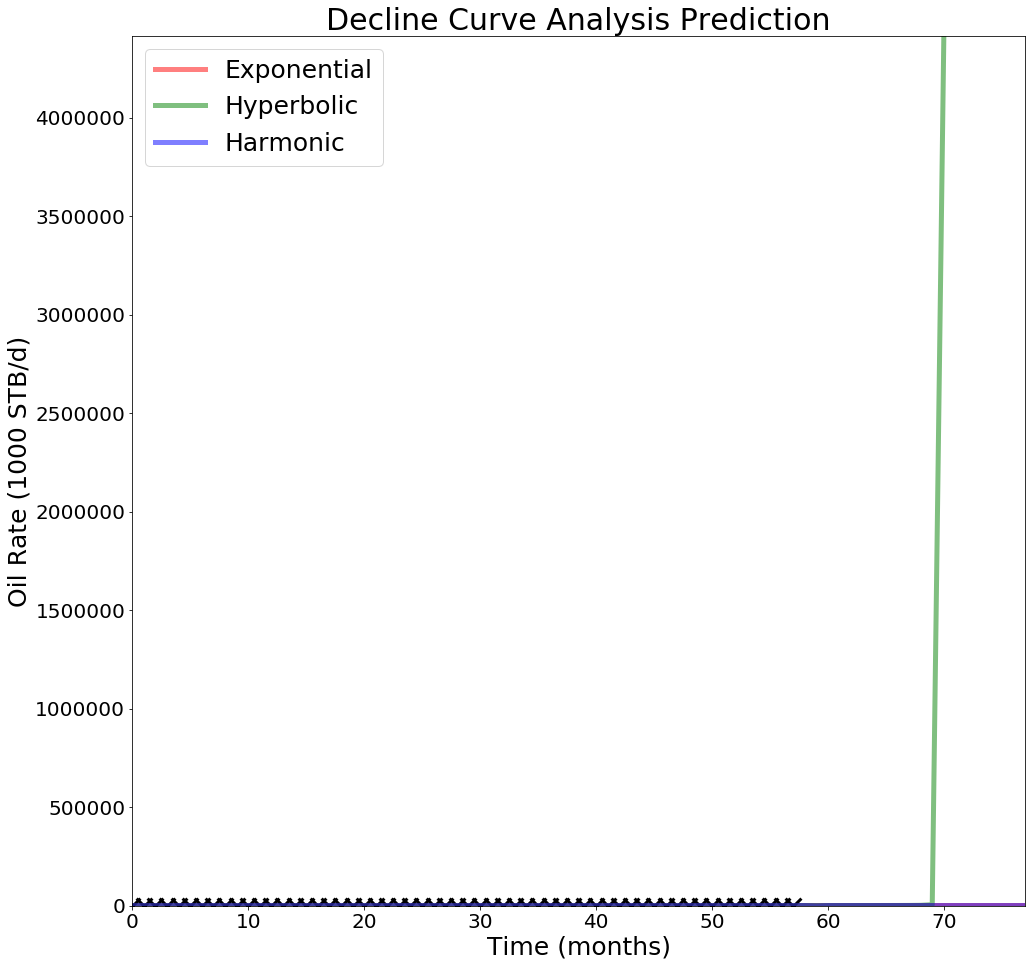

In [412]:
fig, ax = plt.subplots(1, figsize=(16, 16))

T_max = len(T)+20.0 #through January 2020
T_pred = np.arange(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction", fontsize=30)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="black", marker="x", s=250, linewidth=3)
ax.set_xlabel("Time (months)", fontsize=25)
ax.set_ylabel("Oil Rate (1000 STB/d)", fontsize=25)

pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])

min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T_pred, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T_pred, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.ticklabel_format(fontsize=25)
ax.legend(fontsize=25)

In [7]:
bigTSoil.replace(np.inf, np.nan, inplace=True)
bigTSoil.replace(to_replace=0.0, value=0.0001, inplace=True)
bigTSoil = bigTSoil.fillna(0.001)

In [16]:
df = pd.DataFrame(index=pd.date_range('1978-01-31', '2019-12-31', freq='M'))
for i in tqdm(range(40000)):
    try:
        Q0=bigTSoil.iloc[0:,i].dropna().values
        Q=Q0[np.where(Q0>50)[0][0]:]
        T=range(0,len(Q))
        
        exp_decline = decline_curve("exponential", Q[np.where(Q>50)[0][0]])
        hyp_decline = decline_curve("hyperbolic", Q[np.where(Q>50)[0][0]])
        har_decline = decline_curve("harmonic", Q[np.where(Q>50)[0][0]])

        popt_hyp, pcov_hyp = curve_fit(har_decline, T, Q, method="trf")
        popt_har, pcov_har = curve_fit(har_decline, T, Q, method="trf")
        popt_exp, pcov_exp = curve_fit(exp_decline, T, Q, method="trf")


        T_max = len(T)+20.0 #through January 2020
        T_pred = np.arange(min(T), T_max)
        #pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
        pred_har = har_decline(T_pred, popt_har[0])
        pred_exp = exp_decline(T_pred, popt_exp[0])


        filled = np.pad(pred_exp, (504-(504-np.where(Q0>50)[0][0]),0),'constant')
        df[bigTSoil.columns[i]] = filled
    except:
        pass


  9%|██████▊                                                                      | 3550/40000 [01:19<13:39, 44.50it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [15:53<00:00, 41.94it/s]


In [14]:
df[df<0] = 0
df[df>100000] = 0

In [89]:
df.iloc[:, df.max().sort_values(ascending=False).index]

TypeError: '>=' not supported between instances of 'str' and 'int'

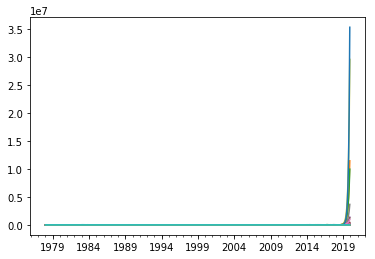

In [17]:
df.iloc[:,0:20000].plot(legend=False)

In [90]:
bigTSoil = bigTSoil.loc[:, bigTSoil.mean().sort_values(ascending=False).index]

In [115]:
bigTSoil.index = pd.to_datetime(bigTSoil.index)

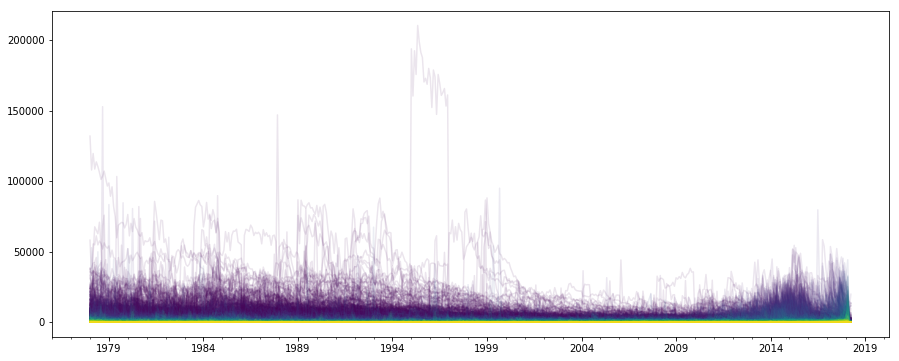

In [118]:
bigTSoil.iloc[0:, 0:41245].plot(legend=False, cmap='viridis', alpha=0.1, figsize=(15,6))

In [117]:
bigTSoil.shape

(484, 41245)